In [1]:
from __future__ import print_function

import tensorflow as tf
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class SequenceData(object):
    def __init__(self, filename, name, seq_max_len):
        if name == "train":
            starting_event = 1
            ending_event = 90
        if name == "test":
            starting_event = 90
            ending_event = 119

        raw_data = pd.read_csv(filename)
        new_data = pd.DataFrame(raw_data, columns=['magnitude','time'])
        l = len(new_data)
        self.data = []
        self.labels = []
        self.seqlen = []
        for num_events in range(starting_event, ending_event):
            tmp = []
            self.seqlen.append(2*num_events-1)
            s = new_data.iloc[0:num_events,:].as_matrix()
            for j in range(num_events):
                tmp.append([s[j][0]])
                if j >0:
                    tmp.append([s[j][1]-s[j-1][1]])
            tmp += [[0] for k in range(seq_max_len - num_events*2 + 1)]
            self.data.append(tmp)
            self.labels.append([new_data.iloc[num_events,1]-new_data.iloc[num_events-1,1]])
        self.batch_id = 0

    def next(self, batch_size):
        """ Return a batch of data. When dataset end is reached, start over.
        """
        if self.batch_id == len(self.data):
            self.batch_id = 0
        batch_data = (self.data[self.batch_id:min(self.batch_id + batch_size, len(self.data))])
        batch_labels = (self.labels[self.batch_id:min(self.batch_id + batch_size, len(self.data))])
        batch_seqlen = (self.seqlen[self.batch_id:min(self.batch_id + batch_size, len(self.data))])
        self.batch_id = min(self.batch_id + batch_size, len(self.data))
        return batch_data, batch_labels, batch_seqlen

In [3]:
# ==========
#   MODEL
# ==========

# Parameters
learning_rate = 0.01
training_iters = 10000
batch_size = 100
display_step = 10

# Network Parameters
n_hidden = 300 # hidden layer num of features
total_num = 120 # total number of event
seq_max_len = 2*total_num-3

trainset = SequenceData("data/example_book3.csv", "train", seq_max_len)
testset = SequenceData("data/example_book3.csv", "test", seq_max_len)

# tf Graph input
x = tf.placeholder("float", [None, seq_max_len, 1])
y = tf.placeholder("float", [None, 1])
# A placeholder for indicating each sequence length
seqlen = tf.placeholder(tf.int32, [None])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, 1]))
}
biases = {
    'out': tf.Variable(tf.random_normal([1]))
}


def dynamicRNN(x, seqlen, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, 1])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(0, seq_max_len, x)

    # Define a lstm cell with tensorflow
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden)

    # Get lstm cell output, providing 'sequence_length' will perform dynamic
    # calculation.
    outputs, states = tf.nn.rnn(lstm_cell, x, dtype=tf.float32, sequence_length=seqlen)

    # When performing dynamic calculation, we must retrieve the last
    # dynamically computed output, i.e., if a sequence length is 10, we need
    # to retrieve the 10th output.
    # However TensorFlow doesn't support advanced indexing yet, so we build
    # a custom op that for each sample in batch size, get its length and
    # get the corresponding relevant output.

    # 'outputs' is a list of output at every timestep, we pack them in a Tensor
    # and change back dimension to [batch_size, n_step, n_input]
    outputs = tf.pack(outputs)
    outputs = tf.transpose(outputs, [1, 0, 2])

    # Hack to build the indexing and retrieve the right output.
    batch_size = tf.shape(outputs)[0]
    # Start indices for each sample
    index = tf.range(0, batch_size) * seq_max_len + (seqlen - 1)
    # Indexing
    outputs = tf.gather(tf.reshape(outputs, [-1, n_hidden]), index)

    # Linear activation, using outputs computed above
    return tf.matmul(outputs, weights['out']) + biases['out']

pred = dynamicRNN(x, seqlen, weights, biases)

# Define loss and optimizer
mse = tf.squared_difference(pred,y)
cost = tf.reduce_mean(mse)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [4]:
# Evaluate model
# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y, batch_seqlen = trainset.next(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, seqlen: batch_seqlen})
        if step % display_step == 0:
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y, seqlen: batch_seqlen})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss))
        step += 1
    print("Optimization Finished!")

    # Calculate accuracy
    test_data = testset.data
    test_label = testset.labels
    test_seqlen = testset.seqlen
    res = sess.run((cost,pred,y), feed_dict={x: test_data, y: test_label, seqlen: test_seqlen})

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Iter 1000, Minibatch Loss= 984.043701
Iter 2000, Minibatch Loss= 961.506836
Iter 3000, Minibatch Loss= 950.880249
Iter 4000, Minibatch Loss= 937.273621
Iter 5000, Minibatch Loss= 932.160095
Iter 6000, Minibatch Loss= 932.163513
Iter 7000, Minibatch Loss= 932.589539
Iter 8000, Minibatch Loss= 920.883240
Iter 9000, Minibatch Loss= 936.091309
Optimization Finished!


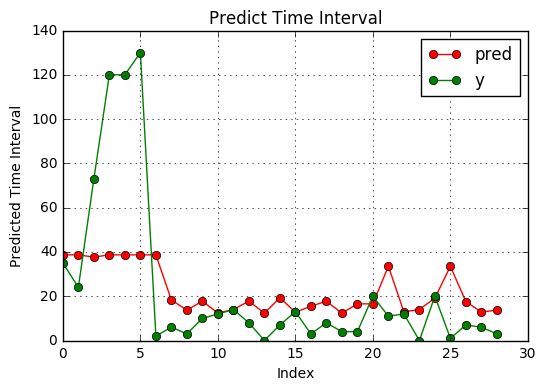

In [5]:
plt.title("Predict Time Interval")
plt.xlabel("Index")
plt.ylabel("Predicted Time Interval")
plt.plot(range(len(res[1])),res[1],'o-',color = 'r',label = "pred")
plt.plot(range(len(res[2])),res[2],'o-',color = 'g', label = "y")
plt.legend(loc = 'upper right')
plt.grid()
plt.show()